In [1]:
import datetime
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
%matplotlib inline  
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import pickle

Using TensorFlow backend.


# Preprocess

We need to preprocess the keys. 

We need to turn the training data into tensors. 
* train_features, train_labels, 
* test_features, test_labels,
* submission_features

In [2]:
keys = {}
with open('key_2.csv', encoding="utf8") as f:
    for line in csv.reader(f):
        keys[line[0]] = line[1]

In [3]:
"""
Clip all outliers to 1 std dev

features = array of 490 days before (scaled to 0-1.0)
Labels = next 60 days (0-1.0)
"""
def convert(s):
    if len(s.strip()):
        if float(s) != 0.0:
            return float(s)
        else: 
            return 0.01
    else:
        return 0.01

with open('time_data.pickle', 'wb') as handle:
    time_data = []
    names = []
    with open('train_2.csv', encoding="utf8") as f:
        reader = csv.reader(f)
        first = True
        s = 0
        for page in reader:
            if not first:
                names.append(page[0])
                time_data.append(np.array(list(map(lambda point: np.array([convert(point)]), page[1:]))))
            first = False
            if s % 1300 ==0:
                print(s)
            s += 1
    time_data = np.array(time_data)
    pickle.dump(time_data,handle)


0
1300
2600
3900
5200
6500
7800
9100
10400
11700
13000
14300
15600
16900
18200
19500
20800
22100
23400
24700
26000
27300
28600
29900
31200
32500
33800
35100
36400
37700
39000
40300
41600
42900
44200
45500
46800
48100
49400
50700
52000
53300
54600
55900
57200
58500
59800
61100
62400
63700
65000
66300
67600
68900
70200
71500
72800
74100
75400
76700
78000
79300
80600
81900
83200
84500
85800
87100
88400
89700
91000
92300
93600
94900
96200
97500
98800
100100
101400
102700
104000
105300
106600
107900
109200
110500
111800
113100
114400
115700
117000
118300
119600
120900
122200
123500
124800
126100
127400
128700
130000
131300
132600
133900
135200
136500
137800
139100
140400
141700
143000
144300


In [4]:
catagories = {}
index = 0
for name in names:
    cat = name.split('.wikipedia.org')[0].split('_')[-1]
    if cat in catagories:
        catagories[cat].append((name,index))
    else:
        catagories[cat] = [(name,index)]
    index +=1

In [5]:
print (catagories.keys())
for cat in catagories:
    print(len(catagories[cat]))

dict_keys(['zh', 'fr', 'en', 'spider', 'ru', 'all-agents', 'de', 'ja', 'es'])
17229
17802
24108
4299
15022
13556
18547
20431
14069


# Normalizing

In [6]:
with open('time_data.pickle', 'rb') as handle:
    time_data = pickle.load(handle)
    
weights, biases = [], []
new_time_data = []

for page in time_data:
    logged_data = np.log(page)
    mean = np.mean(logged_data[:,0])
    std_dev = np.std(logged_data[:,0])

    #clipped_data = np.clip(logged_data, mean-std_dev,mean+std_dev)
    
    biases.append(mean)
    weights.append(std_dev*4)

    result = np.divide(np.add(logged_data,(-mean)), std_dev*4)
    new_time_data.append(result)

    
new_time_data = np.array(new_time_data)
print (new_time_data.shape)

(145063, 550, 1)


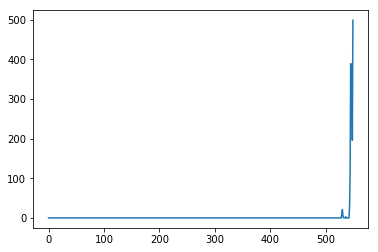

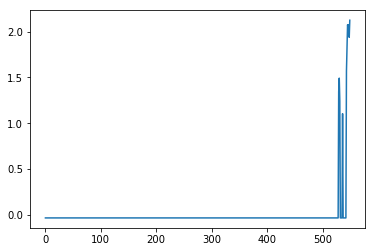

In [7]:
i = random.randint(0,13000)
plt.plot(time_data[i])
plt.show()
plt.plot(new_time_data[i])
plt.show()

# Train Test Split

In [8]:
input_size = 400
output_size = 60
source_size = len(new_time_data[0])
multiply = 10
features = []
labels = []

for i in range(len(new_time_data)):
    for _ in range(multiply):
        offset = random.randint(0,source_size-input_size-output_size)
        end = offset + input_size
        features.append(new_time_data[i,offset:end])
        labels.append(new_time_data[i,end:end+output_size,0])
    
features = np.array(features)
labels = np.array(labels)
    
    
x_validation = new_time_data[:,source_size-input_size-output_size:source_size-output_size]
y_validation = new_time_data[:,source_size-output_size:,0]

x_submit = new_time_data[:,source_size-input_size:]

X_train = features
y_train = labels
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

print(features.shape)

(1450630, 400, 1)


# Train Model

In [9]:
from keras import backend as K
def loss(y_true, y_pred):
    y_true += 0.00000001
    return K.mean(K.abs((K.exp(y_true) - K.exp(y_pred)) / ((K.abs(K.exp(y_true)) + K.abs(K.exp(y_pred))) / 2.0)), axis=-1) * 100

In [10]:

# model = Sequential()
# model.add(Conv1D(64,kernel_size=32, input_shape=(input_size,1), padding='causal'))

# model.add(Conv1D(32,kernel_size=64, padding='causal'))
# model.add(Dropout(0.2))
# model.add(Conv1D(32,kernel_size=128, padding='causal'))
# model.add(Dropout(0.2))
# model.add(Conv1D(32,kernel_size=64, padding='causal'))
# model.add(Dropout(0.2))
# model.add(Conv1D(16,kernel_size=16, padding='causal'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(output_size, activation='linear', use_bias=True))

model = Sequential()
model.add(Conv1D(128,kernel_size=128, input_shape=(input_size,1), padding='causal', activation='linear'))
model.add(Conv1D(128,kernel_size=16, padding='causal', activation='relu'))
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=16, padding='causal', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(8))
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(2048, activation='relu'))

model.add(Dense(output_size, activation='linear'))

# Compile model
model.compile(loss=loss, optimizer='Adadelta', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 128)          16512     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 128)          262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 64)           131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [11]:
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=False)
model.fit(X_train, y_train, validation_split=0.3, epochs=3, batch_size=100,shuffle=True,callbacks=[checkpoint])

Train on 1015440 samples, validate on 435190 samples
Epoch 1/3
1015440/1015440 [==============================] - 554s - loss: 12.2257 - acc: 0.0472 - val_loss: 13.2720 - val_acc: 0.0420
Epoch 2/3
1015440/1015440 [==============================] - 548s - loss: 11.4433 - acc: 0.0552 - val_loss: 12.9807 - val_acc: 0.0436
Epoch 3/3
1015440/1015440 [==============================] - 549s - loss: 11.2321 - acc: 0.0584 - val_loss: 12.7886 - val_acc: 0.0463


In [12]:
model.load_weights("weights.hdf5")
pred = model.predict(x_validation)

# Validation

In [13]:
# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2.0))) * 100.0

#y_pred_fixed, y_true_fixed = [], time_data[:,source_size-output_size:,0]
y_pred_fixed, y_true_fixed = [], time_data[:,source_size-output_size:,0]

for page_id in range(len(pred)):
    result = np.round(np.exp(np.add(np.multiply(pred[page_id], weights[page_id]),biases[page_id])))
    y_pred_fixed.append(result)
    
y_pred_fixed = np.array(y_pred_fixed)
print (mean_absolute_percentage_error(y_true_fixed, y_pred_fixed))

46.9712630269


In [27]:
bad_indexes = sorted(range(len(y_pred_fixed)), 
                     key=lambda index: mean_absolute_percentage_error(y_true_fixed[index], y_pred_fixed[index]))

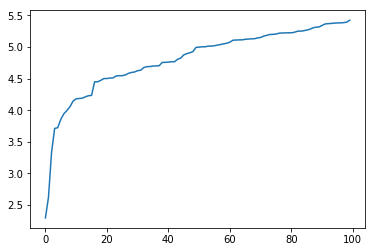

In [38]:
scores = list(map(lambda index: mean_absolute_percentage_error(y_true_fixed[index], y_pred_fixed[index]),range(len(y_pred_fixed))))

200.0


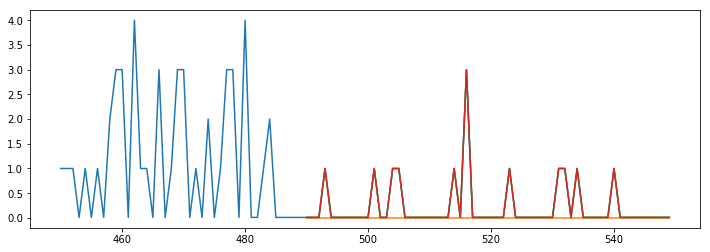

200.0


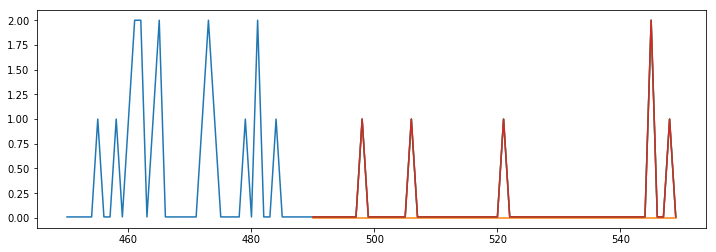

200.0


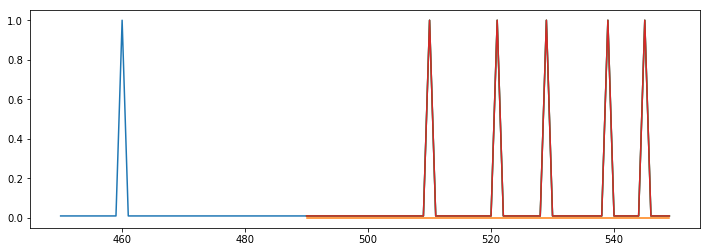

200.0


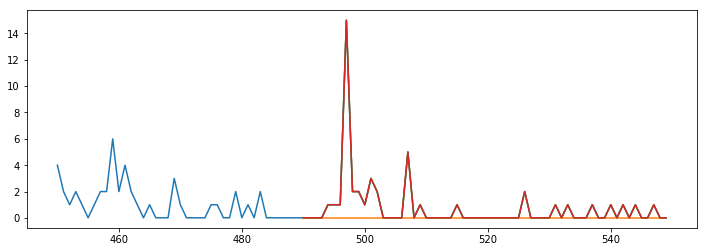

200.0


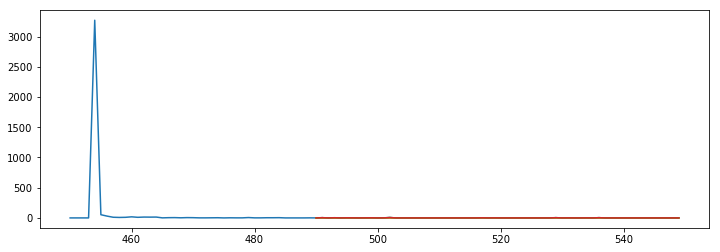

200.0


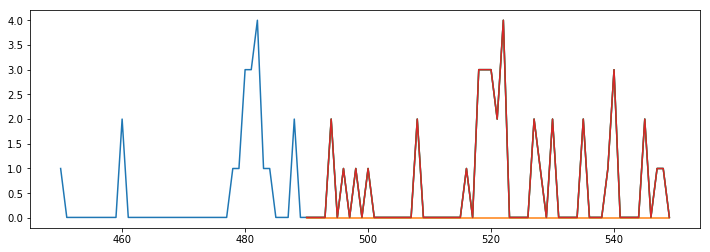

200.0


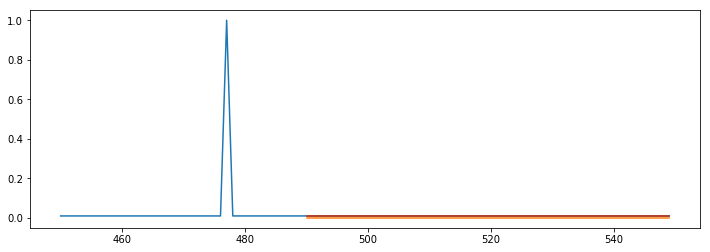

200.0


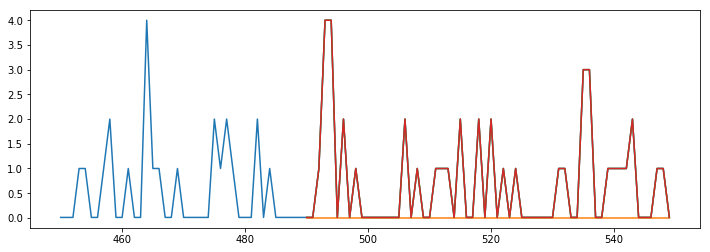

200.0


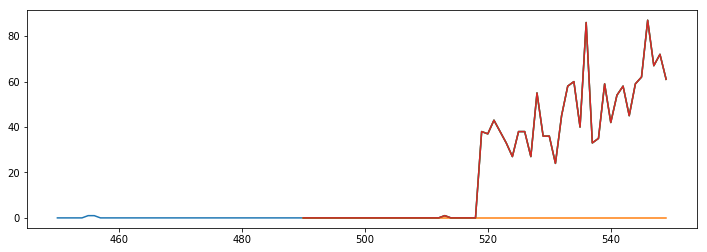

200.0


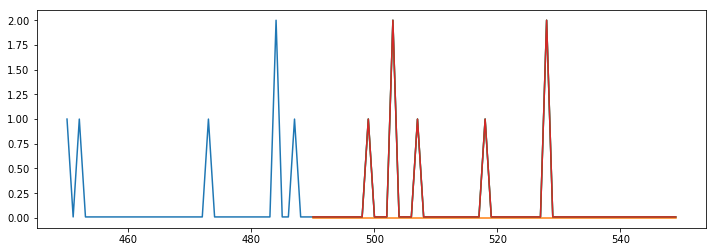

200.0


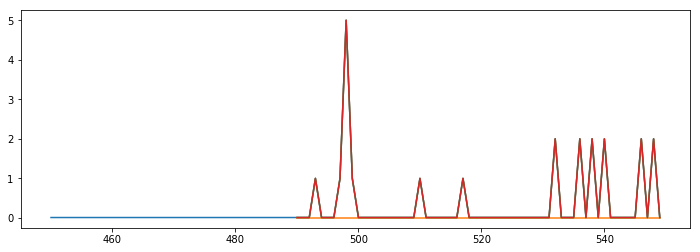

200.0


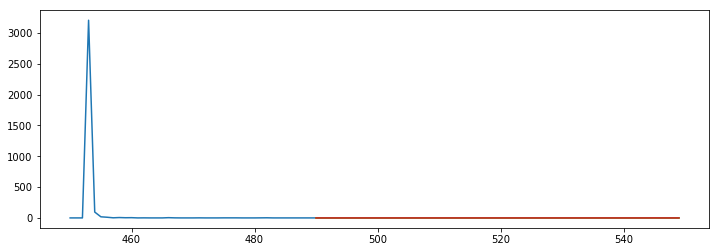

200.0


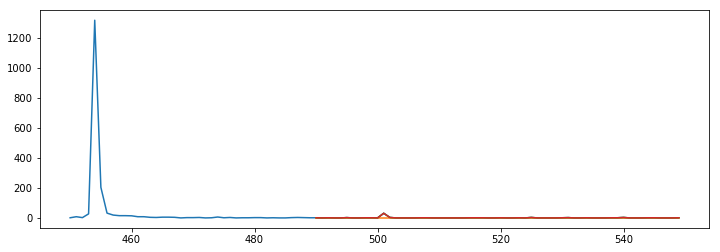

200.0


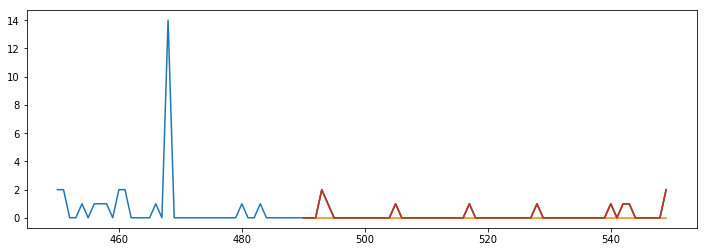

200.0


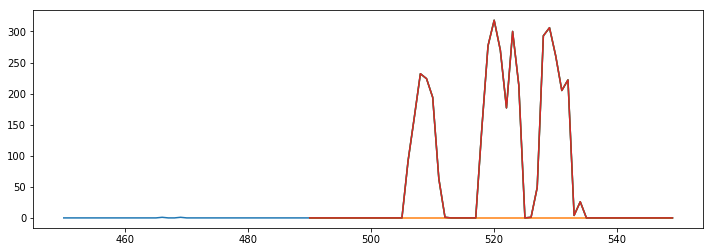

200.0


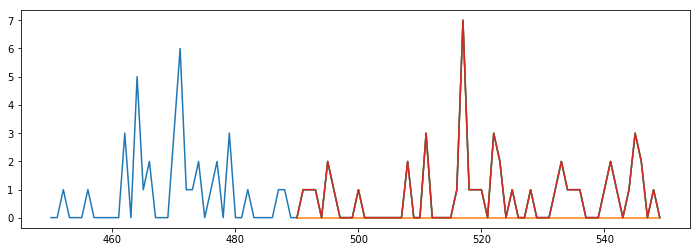

200.0


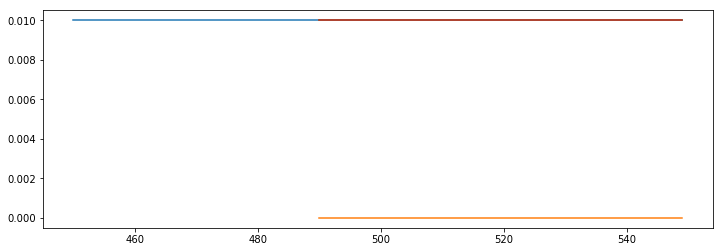

200.0


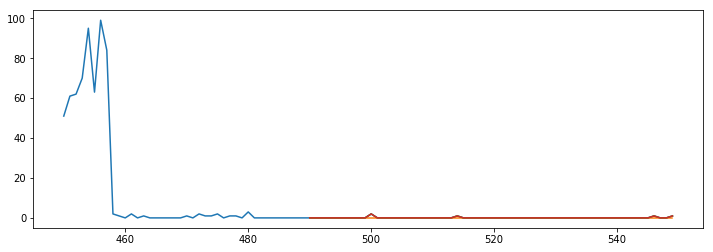

200.0


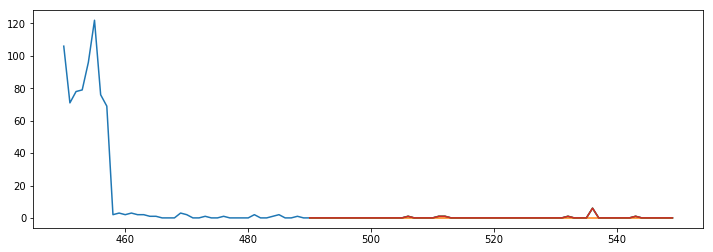

200.0


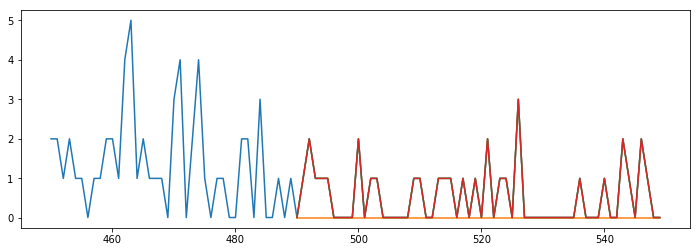

200.0


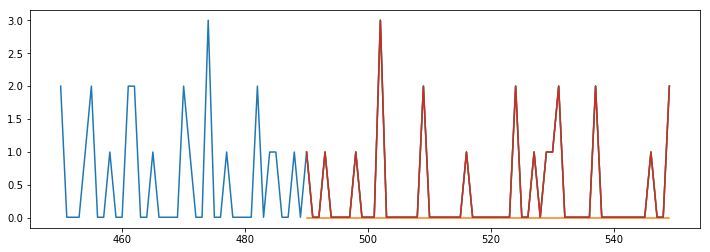

200.0


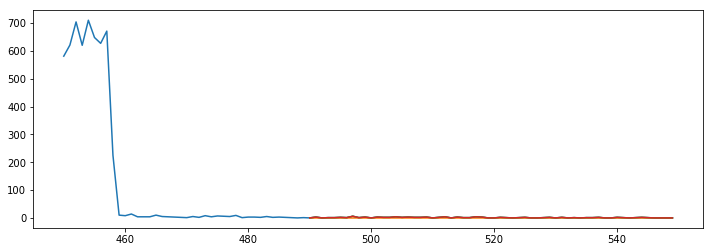

200.0


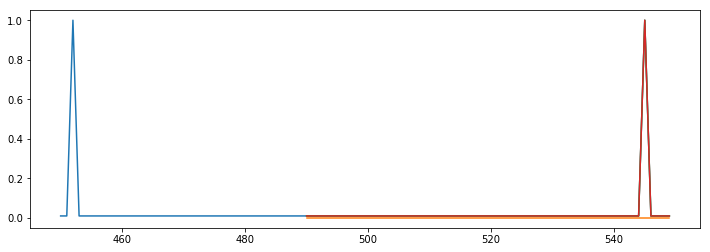

200.0


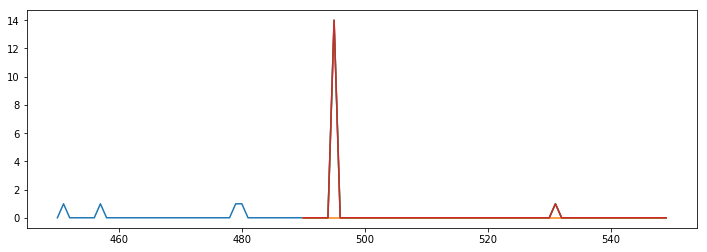

200.0


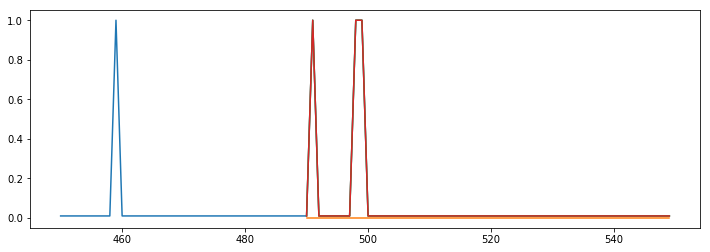

200.0


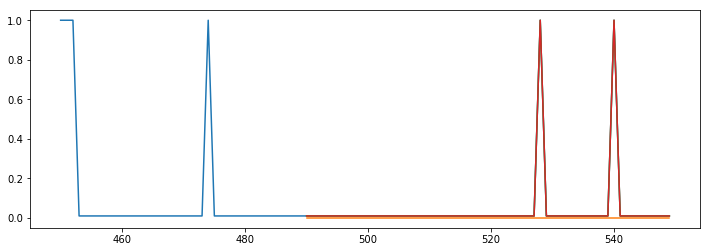

200.0


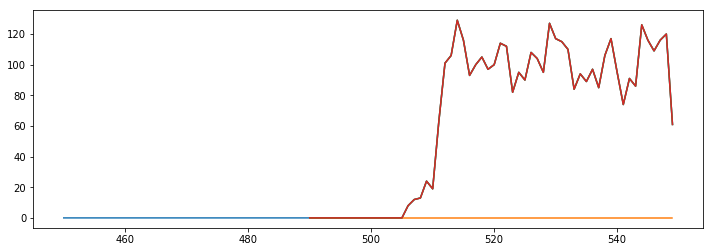

200.0


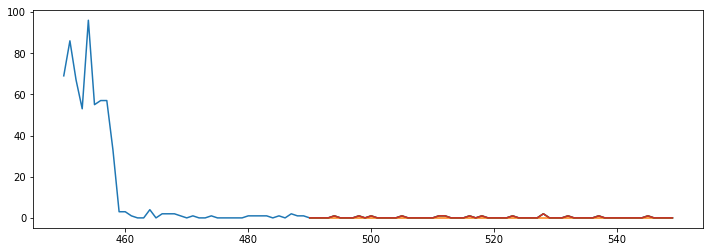

200.0


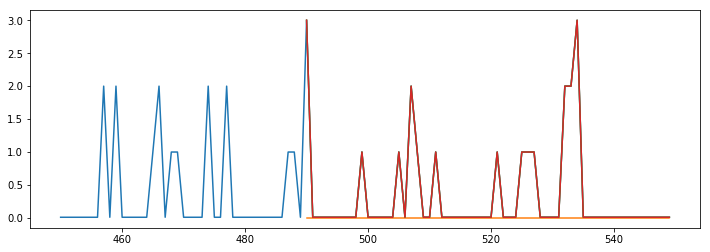

200.0


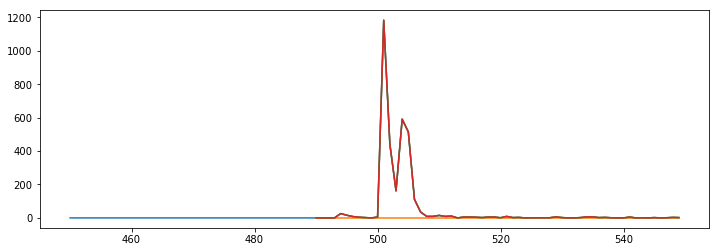

200.0


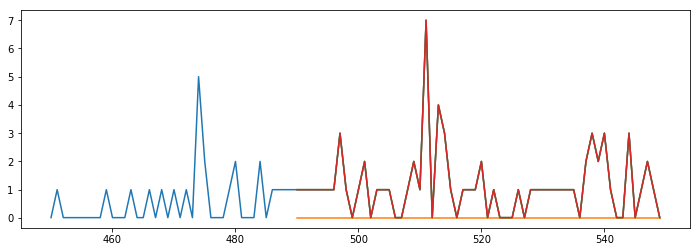

200.0


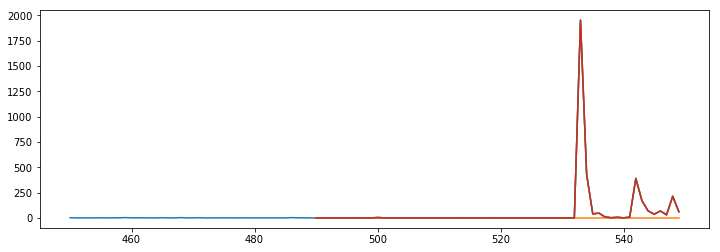

200.0


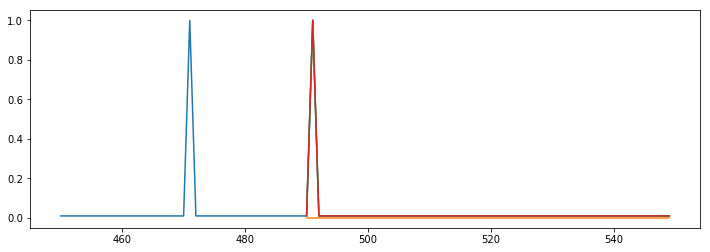

200.0


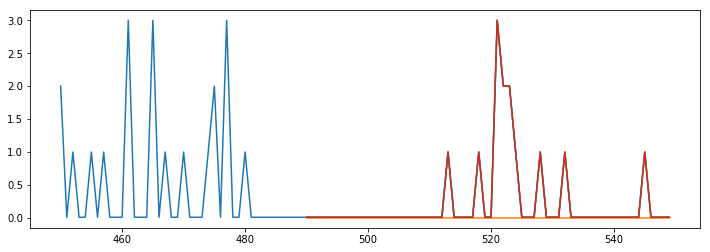

200.0


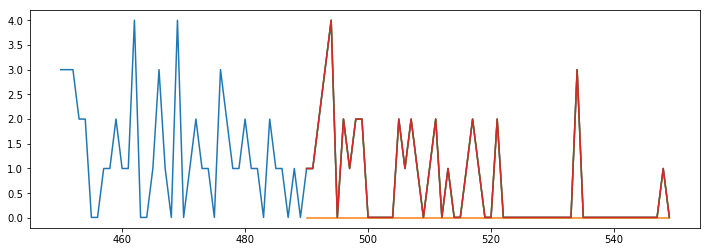

200.0


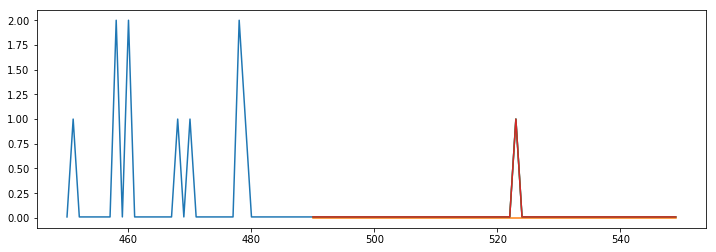

200.0


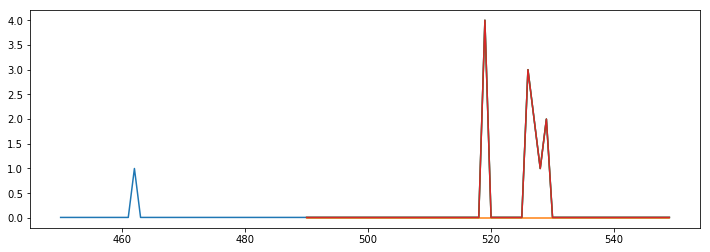

200.0


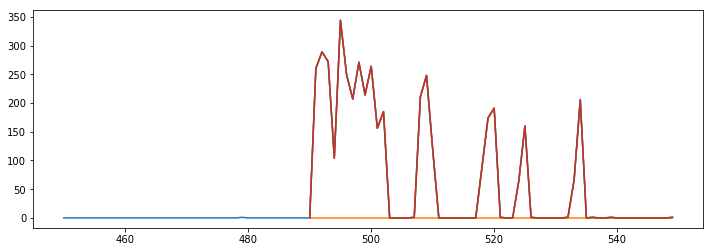

200.0


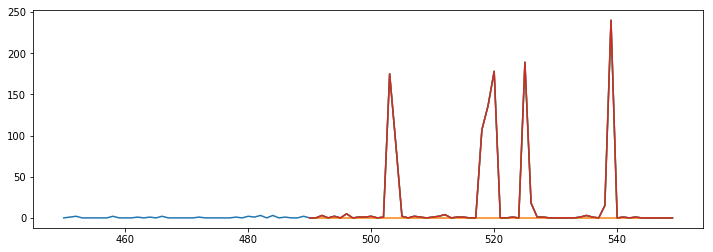

200.0


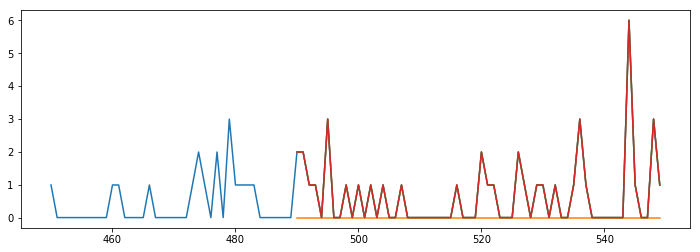

200.0


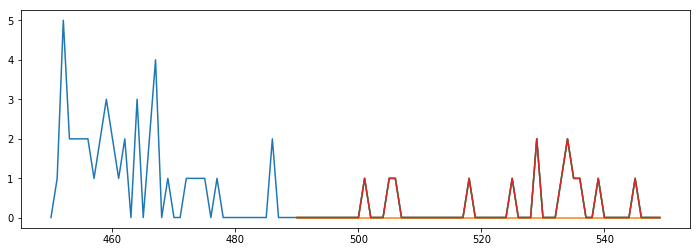

200.0


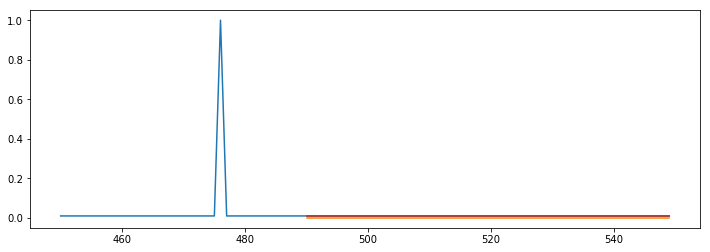

200.0


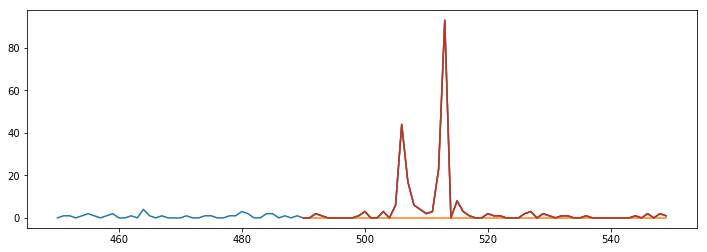

200.0


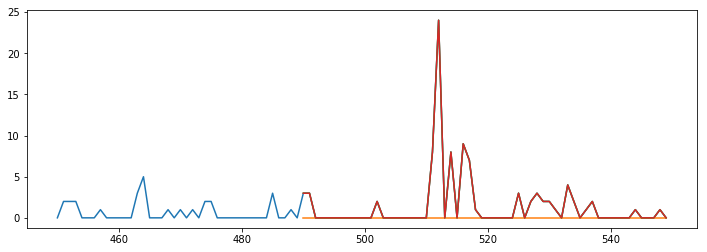

200.0


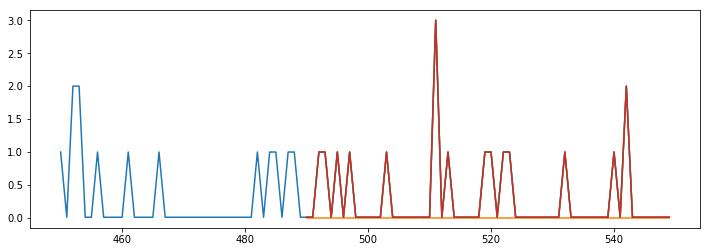

200.0


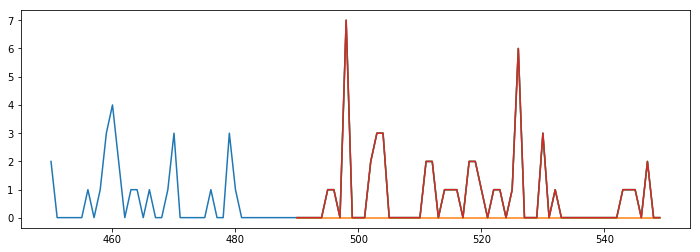

200.0


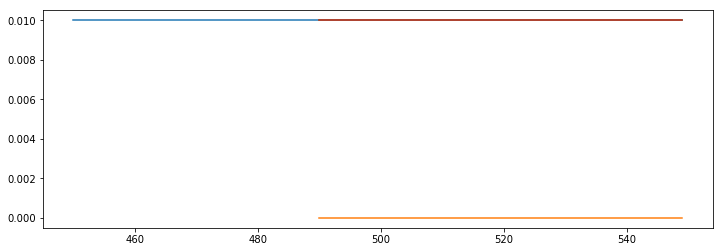

200.0


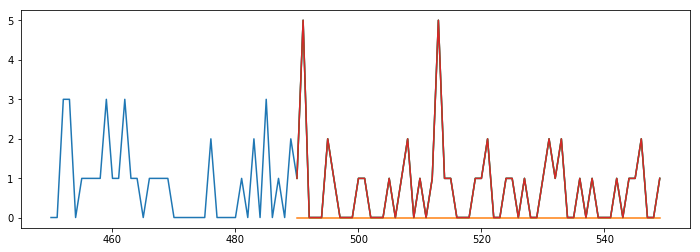

200.0


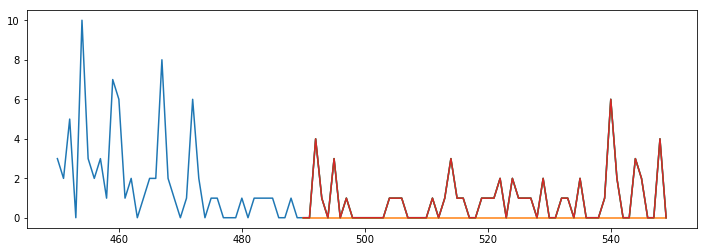

200.0


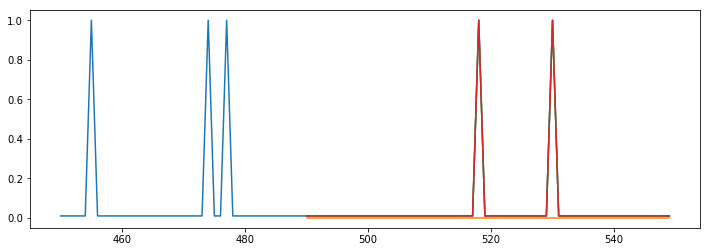

200.0


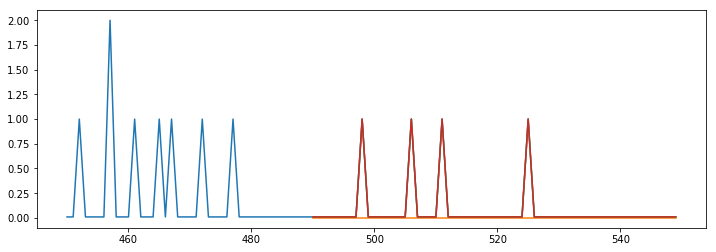

200.0


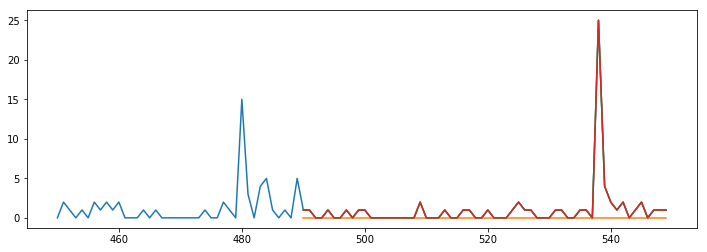

200.0


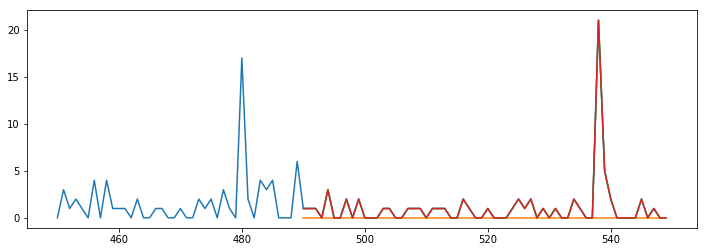

200.0


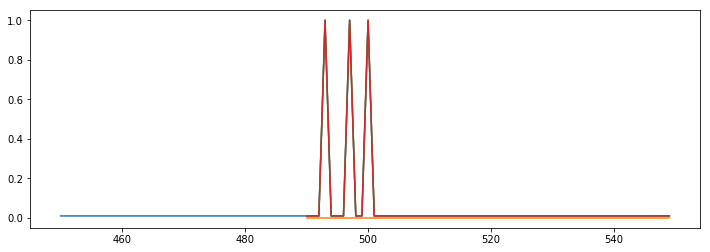

200.0


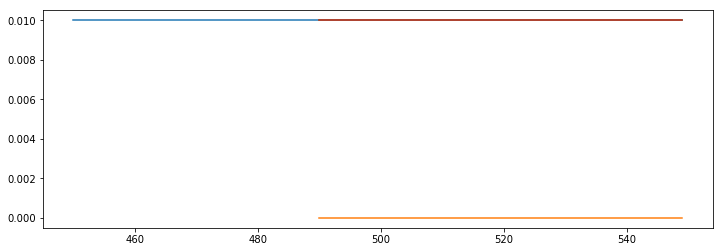

200.0


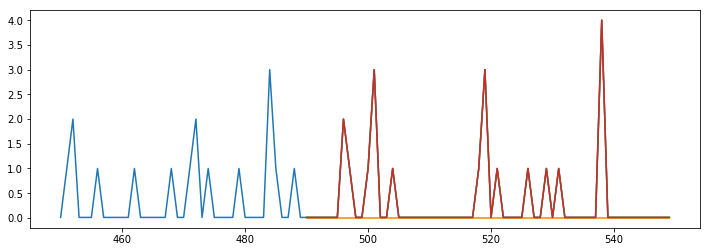

200.0


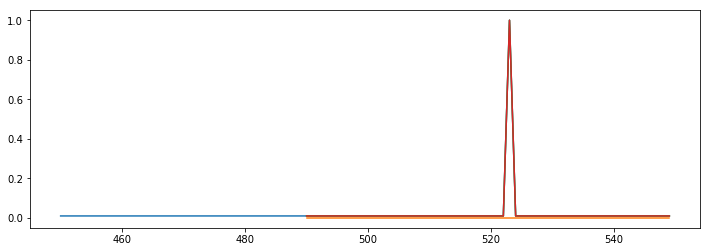

200.0


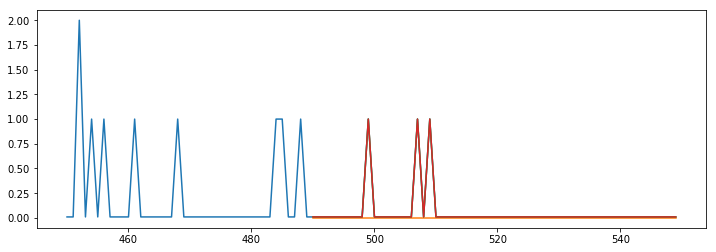

200.0


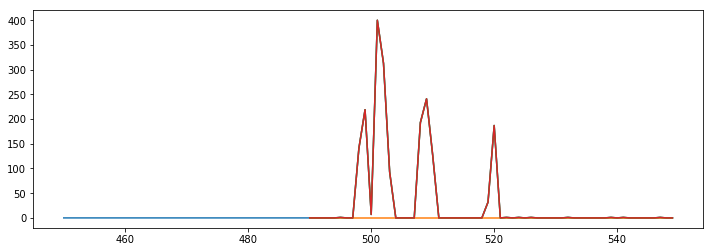

200.0


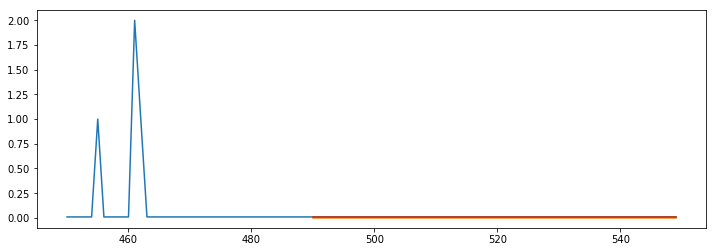

In [44]:
for i in bad_indexes[-2060:-2000]:
    plt.figure(figsize=(12,4))
    k = i
    print(scores[i])
    plt.plot(range(450,550),time_data[k,450:550])
    plt.plot(range(source_size-output_size,550),y_pred_fixed[k])
    plt.plot(range(source_size-output_size,550),y_true_fixed[k])
    plt.plot(range(source_size-output_size,550),np.abs(y_pred_fixed[k]-y_true_fixed[k]))
    plt.show()

# Make Predictions

In [16]:
y_results = model.predict(x_submit)
y_results_fixed = []
for page_id in range(len(y_results)):
    result = np.round(np.exp(np.add(np.multiply(y_results[page_id], weights[page_id]),biases[page_id])))
    y_results_fixed.append(result)
y_results_fixed = np.array(y_results_fixed)

# Render output

In [17]:
with open('sub.csv','w+') as o:
    o.write('Id,Visits\n')
    for i in range(len(y_results_fixed)):
        for j in range(len(y_results_fixed[i])):
            date = datetime.datetime(2017, 1, 1) + datetime.timedelta(j)
            id = keys["{}_{}".format(names[i], date.strftime('%Y-%m-%d'))]
            o.write('{},{}\n'.format(id, int(y_results_fixed[i][j])))

In [18]:
print(y_results_fixed.shape)

(145063, 60)


In [19]:
print(145063* 60)

8703780


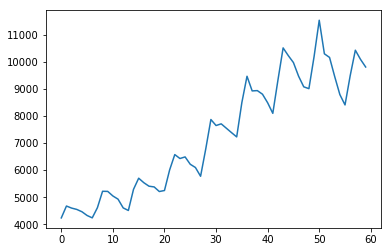

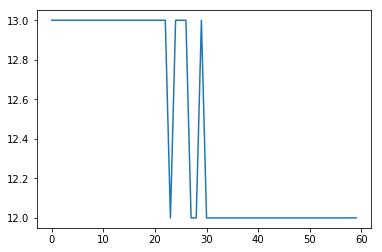

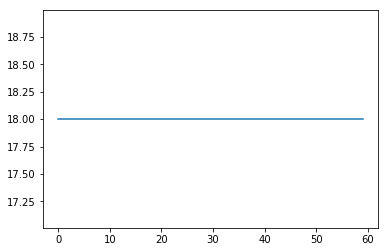

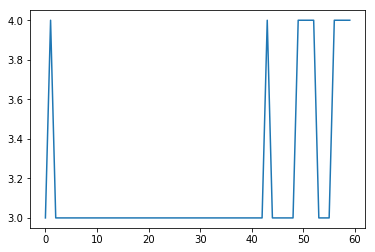

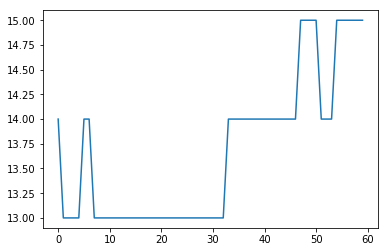

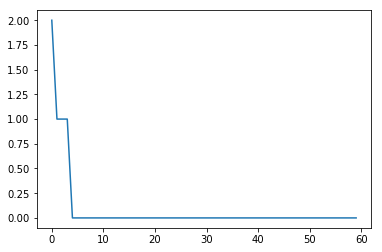

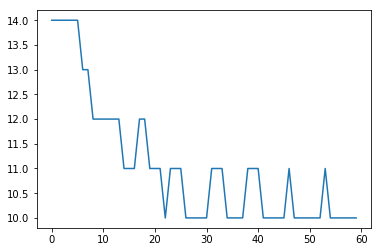

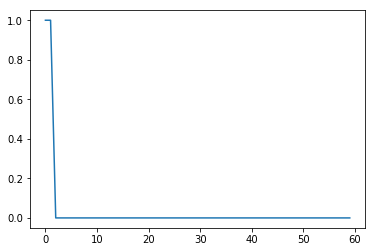

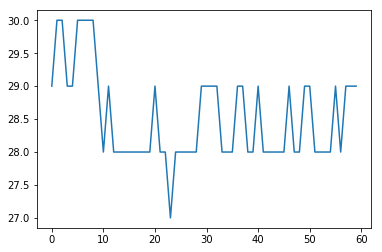

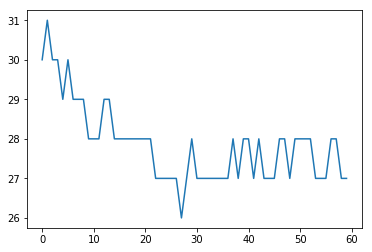

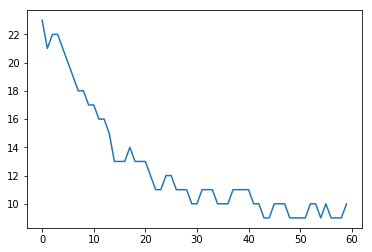

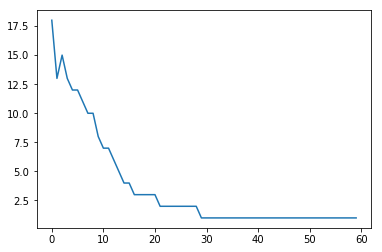

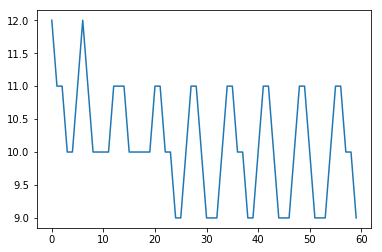

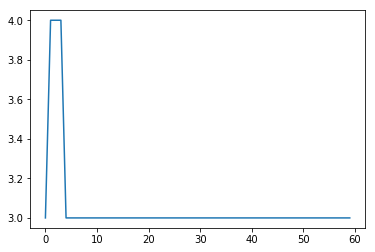

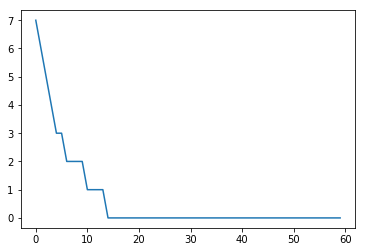

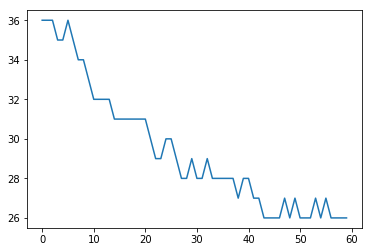

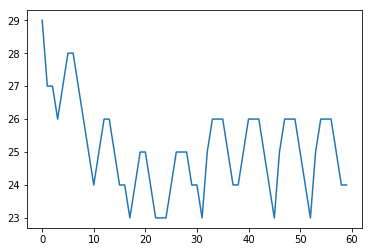

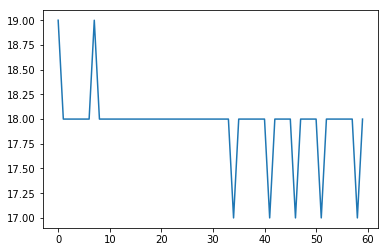

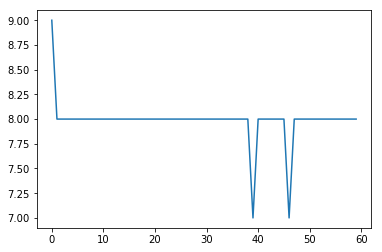

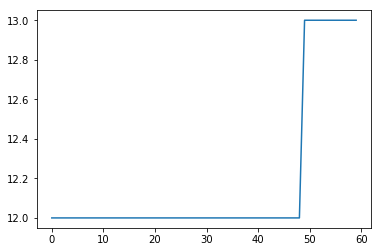

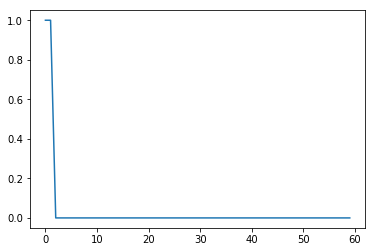

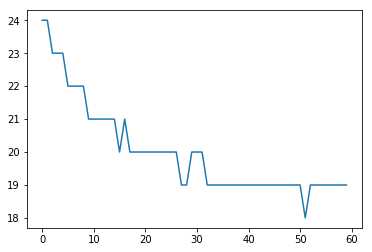

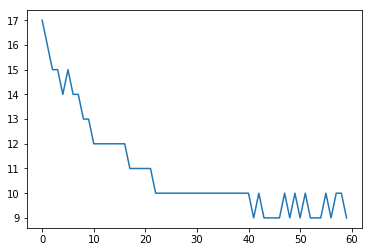

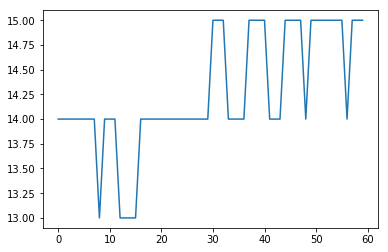

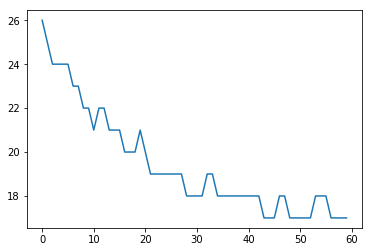

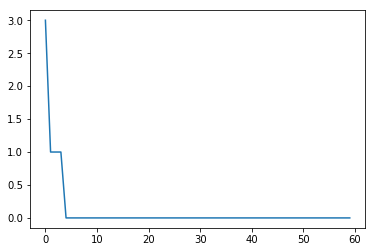

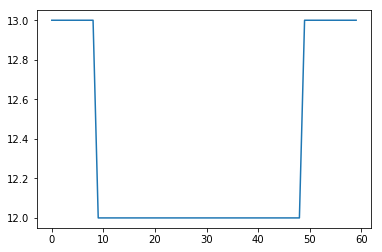

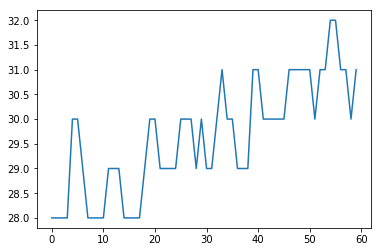

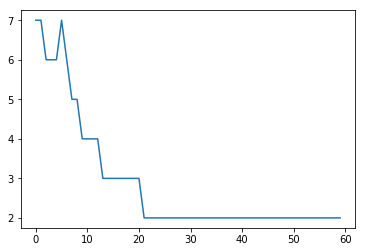

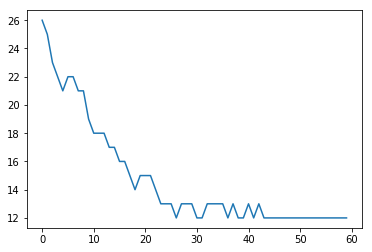

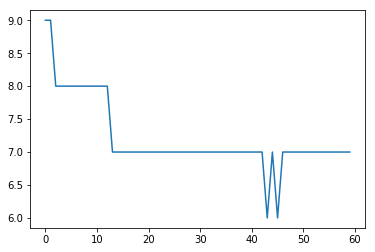

In [20]:
plt.plot(y_results_fixed[10017])
plt.show()
for i in range(30):
    plt.plot(y_results_fixed[i])
    plt.show()
    
